In [1]:
# Cell 2: Imports and global configuration

import math
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

import numpy as np
import matplotlib.pyplot as plt

# Use a reasonably fixed seed for reproducibility (you can loop over many runs later)
SEED = 1234

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Global hyperparameters (can be tweaked)
BATCH_SIZE = 10
LR = 1e-3
EPOCHS_PER_TASK = 5
OGD_GRADS_PER_TASK = 200  # as in the paper


Using device: cuda


In [2]:
# Cell 3: MLP model definitions

class MLP(nn.Module):
    """
    3-layer MLP with:
    - Input: 784 (28x28)
    - Hidden: 100, 100
    - Output: num_classes (default 10)
    Used for Permuted/Rotated MNIST (single-head).
    """
    def __init__(self, input_dim=784, hidden_dim=100, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, 1, 28, 28)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc_out(x)
        return logits


class MultiHeadMLP(nn.Module):
    """
    Shared MLP trunk with multiple task-specific heads.
    Used for Split MNIST: 5 tasks × 2 classes (default).
    """
    def __init__(self, input_dim=784, hidden_dim=100, num_heads=5, head_output_sizes=None):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        if head_output_sizes is None:
            head_output_sizes = [10] * num_heads
        assert len(head_output_sizes) == num_heads

        self.heads = nn.ModuleList([
            nn.Linear(hidden_dim, out_dim) for out_dim in head_output_sizes
        ])

    def forward(self, x, task_id):
        # x: (B, 1, 28, 28), task_id: int in [0, num_heads-1]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.heads[task_id](x)
        return logits


In [3]:
# Cell 4: Utilities to flatten/unflatten gradients

def get_grad_vector(model):
    """
    Concatenate all parameter gradients into a single 1D tensor.
    If some gradients are None, treat them as zeros.
    """
    grads = []
    for p in model.parameters():
        if p.grad is None:
            grads.append(torch.zeros_like(p.data).view(-1))
        else:
            grads.append(p.grad.view(-1))
    return torch.cat(grads)


def set_grad_vector(model, grad_vector):
    """
    Set model.grad tensors from a single 1D gradient vector.
    """
    idx = 0
    for p in model.parameters():
        numel = p.data.numel()
        g = grad_vector[idx:idx+numel].view_as(p.data)
        if p.grad is None:
            p.grad = torch.zeros_like(p.data)
        p.grad.copy_(g)
        idx += numel


In [4]:
# Cell 5: OGD memory — store orthogonal directions and project gradients

class OGDMem:
    """
    OGD memory for gradient directions:
    - Stores a list of orthonormal vectors (flattened grads).
    - Projects new gradients to the subspace orthogonal to these vectors.
    This corresponds to OGD-GTL (using ground-truth logit gradients).
    """
    def __init__(self, max_directions=OGD_GRADS_PER_TASK * 10):
        # max_directions ~ (#tasks-1)*OGD_GRADS_PER_TASK (rough upper bound)
        self.vectors = []  # list of 1D tensors (unit-norm)
        self.max_directions = max_directions

    @torch.no_grad()
    def add_direction(self, v):
        """
        Add a new direction v (1D tensor) to the memory using Gram-Schmidt
        to keep vectors approximately orthonormal.
        """
        if len(self.vectors) >= self.max_directions:
            return  # memory full

        # Make a copy on same device
        v = v.clone()
        # Subtract projection on existing directions
        for s in self.vectors:
            proj = torch.dot(v, s) * s  # s is unit norm
            v -= proj

        # If non-trivial, normalize and store
        norm = torch.norm(v)
        if norm > 1e-8:
            v = v / norm
            self.vectors.append(v)

    @torch.no_grad()
    def project(self, g):
        """
        Project g into the subspace orthogonal to stored directions.
        Returns: g_tilde
        """
        if not self.vectors:
            return g

        g_tilde = g.clone()
        for s in self.vectors:
            dot = torch.dot(g_tilde, s)
            g_tilde = g_tilde - dot * s
        return g_tilde


In [15]:
# Cell 6: Collect OGD gradient directions from a task (GTL)


def collect_ogd_directions(
    memory,
    model,
    data_loader,
    num_directions=OGD_GRADS_PER_TASK,
    device=device,
    multihead=False,
    task_id=None
):
    """
    Collect up to `num_directions` gradient directions of the ground-truth logit
    for OGD-GTL, from the given task's training loader.

    For each selected sample (x, y):
      - Forward pass, pick logit[y], backprop to get ∇_w f_y(x).
      - Flatten the gradients and add to OGD memory via Gram-Schmidt.
    """
    model.eval()
    collected = 0

    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        batch_size = x.size(0)
        for i in range(batch_size):
            if collected >= num_directions:
                return

            model.zero_grad()
            xi = x[i:i+1]
            yi = y[i:i+1]

            if multihead:
                assert task_id is not None, "task_id must be provided for multihead OGD"
                logits = model(xi, task_id=task_id)
            else:
                logits = model(xi)

            # Ground truth logit
            gt_logit = logits[0, yi.item()]
            gt_logit.backward()

            grad_vec = get_grad_vector(model).detach()
            memory.add_direction(grad_vec)
            collected += 1

    print(f"Collected {collected} OGD directions for task_id={task_id}.")


In [6]:
# Cell 7: Training and evaluation helpers

def train_one_epoch(
    model,
    optimizer,
    train_loader,
    device=device,
    ogd_memory=None,
    multihead=False,
    task_id=None
):
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        if multihead:
            logits = model(x, task_id=task_id)
        else:
            logits = model(x)

        loss = criterion(logits, y)
        loss.backward()

        if ogd_memory is not None and len(ogd_memory.vectors) > 0:
            # Flatten gradient, project, then restore
            g = get_grad_vector(model)
            g_tilde = ogd_memory.project(g)
            set_grad_vector(model, g_tilde)

        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate(model, data_loader, device=device, multihead=False, task_id=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        if multihead:
            logits = model(x, task_id=task_id)
        else:
            logits = model(x)

        loss = criterion(logits, y)
        preds = logits.argmax(dim=1)

        total_loss += loss.item() * x.size(0)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


In [7]:
# Cell 8: Dataset utilities for Permuted and Rotated MNIST

class PermutePixels(object):
    """
    Transform that permutes the pixels of a (1, 28, 28) tensor
    according to a fixed permutation of 784 indices.
    """
    def __init__(self, permutation):
        self.permutation = permutation

    def __call__(self, x):
        # x: (1, 28, 28)
        c, h, w = x.size()
        flat = x.view(-1)
        permuted = flat[self.permutation]
        return permuted.view(c, h, w)


class FixedRotation(object):
    """
    Transform that rotates an image by a fixed angle (in degrees).
    Works on PIL images or tensors via torchvision.transforms.functional.
    """
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        # Use torchvision's functional rotate
        return TF.rotate(img, self.angle)


def build_permuted_mnist_tasks(num_tasks=5, root="./data"):
    """
    Build Permuted-MNIST tasks.
    Each task has a different random pixel permutation but uses the same
    MNIST train/test splits.

    Returns: list of (train_loader, test_loader), permutations list
    """
    tasks = []
    perms = []

    for t in range(num_tasks):
        perm = torch.randperm(28 * 28)
        perms.append(perm)

        transform = transforms.Compose([
            transforms.ToTensor(),
            PermutePixels(perm)
        ])

        train_ds = datasets.MNIST(root=root, train=True, download=True, transform=transform)
        test_ds = datasets.MNIST(root=root, train=False, download=True, transform=transform)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
        tasks.append((train_loader, test_loader))

    return tasks, perms


def build_rotated_mnist_tasks(angles=(0, 10, 20, 30, 40), root="./data"):
    """
    Build Rotated-MNIST tasks with fixed rotation angles (in degrees).
    T1: 0°, T2: 10°, ..., etc.

    Returns: list of (train_loader, test_loader), angles list
    """
    tasks = []

    for angle in angles:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x),  # identity for tensor
        ])

        # We'll apply rotation on PIL, so define separate PIL->tensor pipeline:
        base_transform = transforms.Compose([
            FixedRotation(angle),
            transforms.ToTensor()
        ])

        train_ds = datasets.MNIST(root=root, train=True, download=True, transform=base_transform)
        test_ds = datasets.MNIST(root=root, train=False, download=True, transform=base_transform)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
        tasks.append((train_loader, test_loader))

    return tasks, list(angles)


In [8]:
# Cell 9: Dataset utilities for Split MNIST (multi-head)

class SubsetByClass(Dataset):
    """
    Wrap a base dataset (MNIST) and keep only samples whose label is in `allowed_classes`.
    Map original labels to a contiguous range [0, K-1] for each task.
    """
    def __init__(self, base_dataset, allowed_classes):
        self.base_dataset = base_dataset
        self.allowed_classes = set(allowed_classes)
        self.class_to_new = {c: i for i, c in enumerate(sorted(allowed_classes))}

        self.indices = [
            i for i, (_, label) in enumerate(base_dataset)
            if int(label) in self.allowed_classes
        ]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img, label = self.base_dataset[base_idx]
        label = int(label)
        new_label = self.class_to_new[label]
        return img, new_label


def build_split_mnist_5tasks(root="./data"):
    """
    Build Split MNIST with 5 tasks, each containing 2 digits.
    Tasks: [0,1], [2,3], [4,5], [6,7], [8,9] (you can reshuffle if desired).

    Uses a multi-head network with 5 heads, each head having 2 outputs.

    Returns:
      tasks: list of (train_loader, test_loader)
      digits_per_task: list of lists of original digits
    """
    digits_per_task = [
        [0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9],
    ]

    base_train = datasets.MNIST(root=root, train=True, download=True,
                                transform=transforms.ToTensor())
    base_test = datasets.MNIST(root=root, train=False, download=True,
                               transform=transforms.ToTensor())

    tasks = []
    for digits in digits_per_task:
        train_subset = SubsetByClass(base_train, digits)
        test_subset = SubsetByClass(base_test, digits)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        tasks.append((train_loader, test_loader))

    return tasks, digits_per_task


In [9]:
# Cell 10: Generic continual learning experiment runner

def continual_train(
    tasks,
    model,
    method="ogd",  # "ogd" or "sgd"
    num_epochs=EPOCHS_PER_TASK,
    ogd_grads_per_task=OGD_GRADS_PER_TASK,
    device=device,
    multihead=False
):
    """
    Train `model` sequentially on a list of tasks.
    Args:
      tasks: list of (train_loader, test_loader)
      model: nn.Module
      method: "ogd" or "sgd"
      multihead: if True, expects model(x, task_id)
    Returns:
      results: dict mapping eval_task_id -> list of accuracies after each training task
    """
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    results = defaultdict(list)

    if method == "ogd":
        # Upper bound on total directions: (num_tasks - 1) * ogd_grads_per_task
        memory = OGDMem(max_directions=(len(tasks) - 1) * ogd_grads_per_task)
    else:
        memory = None

    num_tasks = len(tasks)

    for t in range(num_tasks):
        print(f"\n=== Training on task {t} / {num_tasks-1} with method={method} ===")

        train_loader, _ = tasks[t]

        for epoch in range(num_epochs):
            if method == "ogd" and t > 0:
                # Use OGD with memory collected from previous tasks
                loss, acc = train_one_epoch(
                    model,
                    optimizer,
                    train_loader,
                    device=device,
                    ogd_memory=memory,
                    multihead=multihead,
                    task_id=t if multihead else None
                )
            else:
                # Plain SGD (no projection)
                loss, acc = train_one_epoch(
                    model,
                    optimizer,
                    train_loader,
                    device=device,
                    ogd_memory=None,
                    multihead=multihead,
                    task_id=t if multihead else None
                )

            print(f"Task {t} | Epoch {epoch+1}/{num_epochs} | Loss: {loss:.4f} | Acc: {acc*100:.2f}%")

        # After finishing training on task t, evaluate on all tasks seen so far
        print("\nEvaluation after finishing task", t)
        for eval_t in range(t + 1):
            _, test_loader = tasks[eval_t]
            eval_loss, eval_acc = evaluate(
                model,
                test_loader,
                device=device,
                multihead=multihead,
                task_id=eval_t if multihead else None
            )
            results[eval_t].append(eval_acc)
            print(f"  Eval on task {eval_t}: acc = {eval_acc*100:.2f}%")

        # After training task t, if using OGD, collect gradient directions for this task
        if method == "ogd":
            print(f"\nCollecting OGD directions from task {t} ...")
            collect_ogd_directions(
                memory,
                model,
                train_loader,
                num_directions=ogd_grads_per_task,
                device=device,
                multihead=multihead,
                task_id=t if multihead else None
            )

    return results


In [10]:
# Cell 11: Permuted MNIST experiment

def run_permuted_mnist_experiment(num_tasks=5, method="ogd"):
    print(f"\n### Permuted MNIST with {num_tasks} tasks, method={method} ###")
    set_seed(SEED)

    tasks, perms = build_permuted_mnist_tasks(num_tasks=num_tasks, root="./data")

    model = MLP(input_dim=784, hidden_dim=100, num_classes=10)
    results = continual_train(
        tasks,
        model,
        method=method,
        num_epochs=EPOCHS_PER_TASK,
        ogd_grads_per_task=OGD_GRADS_PER_TASK,
        device=device,
        multihead=False
    )

    # Print final per-task accuracies (after training all tasks)
    print("\nFinal accuracies on each task (after all tasks trained):")
    for t in range(num_tasks):
        acc_after_all = results[t][-1]
        print(f"  Task {t}: {acc_after_all*100:.2f}%")

    return results


# Example usage: (uncomment and run)
# perm_results_ogd = run_permuted_mnist_experiment(num_tasks=5, method="ogd")
# perm_results_sgd = run_permuted_mnist_experiment(num_tasks=5, method="sgd")


In [11]:
# Cell 12: Rotated MNIST experiment

def run_rotated_mnist_experiment(angles=(0, 10, 20, 30, 40), method="ogd"):
    print(f"\n### Rotated MNIST with angles={angles}, method={method} ###")
    set_seed(SEED)

    tasks, angle_list = build_rotated_mnist_tasks(angles=angles, root="./data")

    model = MLP(input_dim=784, hidden_dim=100, num_classes=10)
    results = continual_train(
        tasks,
        model,
        method=method,
        num_epochs=EPOCHS_PER_TASK,
        ogd_grads_per_task=OGD_GRADS_PER_TASK,
        device=device,
        multihead=False
    )

    print("\nFinal accuracies on each rotation task (after all tasks trained):")
    for t, angle in enumerate(angle_list):
        acc_after_all = results[t][-1]
        print(f"  Task {t} (rotation={angle}°): {acc_after_all*100:.2f}%")

    return results


# Example usage: (uncomment and run)
# rot_results_ogd = run_rotated_mnist_experiment(angles=(0,10,20,30,40), method="ogd")
# rot_results_sgd = run_rotated_mnist_experiment(angles=(0,10,20,30,40), method="sgd")


In [12]:
# Cell 13: Split MNIST (5 tasks × 2 digits) experiment

def run_split_mnist_experiment(method="ogd"):
    print(f"\n### Split MNIST (5 tasks × 2 digits), method={method} ###")
    set_seed(SEED)

    tasks, digits_per_task = build_split_mnist_5tasks(root="./data")

    num_tasks = len(tasks)
    head_output_sizes = [2] * num_tasks
    model = MultiHeadMLP(
        input_dim=784,
        hidden_dim=100,
        num_heads=num_tasks,
        head_output_sizes=head_output_sizes
    )

    results = continual_train(
        tasks,
        model,
        method=method,
        num_epochs=EPOCHS_PER_TASK,
        ogd_grads_per_task=OGD_GRADS_PER_TASK,
        device=device,
        multihead=True
    )

    print("\nFinal accuracies on each Split task (after all tasks trained):")
    for t, digits in enumerate(digits_per_task):
        acc_after_all = results[t][-1]
        print(f"  Task {t} (digits {digits}): {acc_after_all*100:.2f}%")

    return results, digits_per_task


# Example usage: (uncomment and run)
# split_results_ogd, digits_per_task = run_split_mnist_experiment(method="ogd")
# split_results_sgd, _ = run_split_mnist_experiment(method="sgd")


In [13]:
# Cell 14: Plotting helper to visualize forgetting

def plot_continual_results(results_dict, title="Continual Learning Results"):
    """
    results_dict: output of continual_train, i.e., dict[task_id] -> list[acc_after_task_k]
    Each list is of length (#tasks where we've evaluated this task).
    """
    num_tasks = len(results_dict)
    plt.figure(figsize=(6, 4))
    for task_id, acc_list in sorted(results_dict.items()):
        plt.plot(range(1, len(acc_list) + 1), acc_list, marker="o", label=f"Task {task_id}")
    plt.xlabel("After training task k")
    plt.ylabel("Accuracy on task")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage after running an experiment:
# plot_continual_results(perm_results_ogd, title="Permuted MNIST — OGD")
# plot_continual_results(perm_results_sgd, title="Permuted MNIST — SGD")



### Permuted MNIST with 5 tasks, method=ogd ###

=== Training on task 0 / 4 with method=ogd ===
Task 0 | Epoch 1/5 | Loss: 2.0084 | Acc: 50.03%
Task 0 | Epoch 2/5 | Loss: 0.8341 | Acc: 80.09%
Task 0 | Epoch 3/5 | Loss: 0.4976 | Acc: 86.32%
Task 0 | Epoch 4/5 | Loss: 0.4123 | Acc: 88.45%
Task 0 | Epoch 5/5 | Loss: 0.3721 | Acc: 89.49%

Evaluation after finishing task 0
  Eval on task 0: acc = 90.05%


=== Training on task 1 / 4 with method=ogd ===
Task 1 | Epoch 1/5 | Loss: 0.6972 | Acc: 81.03%
Task 1 | Epoch 2/5 | Loss: 0.4065 | Acc: 88.76%
Task 1 | Epoch 3/5 | Loss: 0.3578 | Acc: 89.95%
Task 1 | Epoch 4/5 | Loss: 0.3309 | Acc: 90.61%
Task 1 | Epoch 5/5 | Loss: 0.3116 | Acc: 91.12%

Evaluation after finishing task 1
  Eval on task 0: acc = 89.44%
  Eval on task 1: acc = 91.71%


=== Training on task 2 / 4 with method=ogd ===
Task 2 | Epoch 1/5 | Loss: 0.6206 | Acc: 81.67%
Task 2 | Epoch 2/5 | Loss: 0.3788 | Acc: 89.31%
Task 2 | Epoch 3/5 | Loss: 0.3356 | Acc: 90.48%
Task 2 | Epoch 4/5

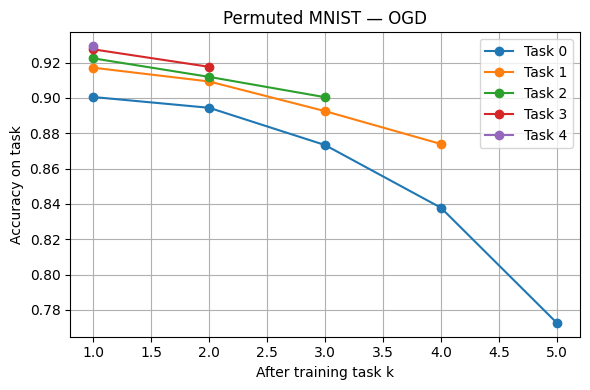

In [16]:
perm_results_ogd = run_permuted_mnist_experiment(num_tasks=5, method="ogd")
plot_continual_results(perm_results_ogd, title="Permuted MNIST — OGD")



### Permuted MNIST with 5 tasks, method=sgd ###

=== Training on task 0 / 4 with method=sgd ===
Task 0 | Epoch 1/5 | Loss: 2.0084 | Acc: 50.03%
Task 0 | Epoch 2/5 | Loss: 0.8341 | Acc: 80.09%
Task 0 | Epoch 3/5 | Loss: 0.4976 | Acc: 86.32%
Task 0 | Epoch 4/5 | Loss: 0.4123 | Acc: 88.45%
Task 0 | Epoch 5/5 | Loss: 0.3721 | Acc: 89.49%

Evaluation after finishing task 0
  Eval on task 0: acc = 90.05%

=== Training on task 1 / 4 with method=sgd ===
Task 1 | Epoch 1/5 | Loss: 0.6830 | Acc: 81.16%
Task 1 | Epoch 2/5 | Loss: 0.3998 | Acc: 88.81%
Task 1 | Epoch 3/5 | Loss: 0.3536 | Acc: 89.95%
Task 1 | Epoch 4/5 | Loss: 0.3278 | Acc: 90.69%
Task 1 | Epoch 5/5 | Loss: 0.3088 | Acc: 91.16%

Evaluation after finishing task 1
  Eval on task 0: acc = 88.40%
  Eval on task 1: acc = 91.91%

=== Training on task 2 / 4 with method=sgd ===
Task 2 | Epoch 1/5 | Loss: 0.5975 | Acc: 82.20%
Task 2 | Epoch 2/5 | Loss: 0.3721 | Acc: 89.40%
Task 2 | Epoch 3/5 | Loss: 0.3303 | Acc: 90.54%
Task 2 | Epoch 4/5 |

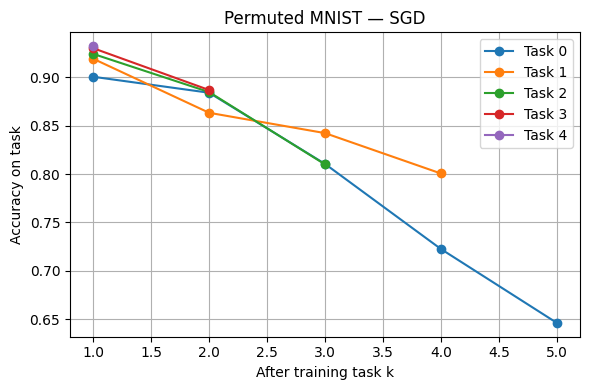

In [17]:
perm_results_sgd = run_permuted_mnist_experiment(num_tasks=5, method="sgd")
plot_continual_results(perm_results_sgd, title="Permuted MNIST — SGD")
